In [ ]:
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import numpy as np
import pyarrow as pa
import time
import os
import concurrent.futures
os.chdir("/home/jovyan/jupyterLogs/")
os.getcwd()

'/home/jovyan/jupyterLogs'

In [2]:
# print file metadata
parquet_file = pq.ParquetFile('inversionloggingGroups/solution.parquet')
print(parquet_file.metadata)
print(parquet_file.schema)

  created_by: parquet-mr version 1.15.1 (build c7257b8faff5699e13bbc781679dc03f48c1102a)
  num_columns: 1
  num_rows: 100001
  num_row_groups: 1001
  format_version: 1.0
  serialized_size: 168119
required group field_id=-1 solution {
  required group field_id=-1 solution (List) {
    repeated double field_id=-1 array;
  }
}



In [3]:
# groups with processses

g_parquet_file = None
g_col_name = None
g_n_result = None
g_kernel = None

# used by parquet_iterator_parallel to process a row group
def read_group_double_row(index):
  global g_parquet_file, g_col_name, g_n_result, g_kernel
  group = g_parquet_file.read_row_group(index).to_pandas()[g_col_name]
  result = np.zeros(shape=(g_n_result, len(group)-1))
  first = None
  previous = None
  index = -1
  for row in group:
    if index >= 0:
      result[:,index] = g_kernel(previous, row)
    else:
      first = row
    previous = row
    index+=1 
  return (first, result, previous)

# used by parquet_iterator_parallel to init new processes
def init_fn(file_name, col_name, kernel, n_result):
  global g_parquet_file, g_col_name, g_n_result, g_kernel
  g_parquet_file = pq.ParquetFile(file_name)
  g_col_name = col_name
  g_n_result = n_result
  g_kernel = kernel
  


def parquet_iterator_parallel(file_name, col_name, kernel, n_result):
  # entry point
  # 
  # file_name: parquet file name
  # col_name: the column of interest
  # kernel: a function that takes two numpy arrays and returns a tuple of n_result length
  # n_result: number of values expected from the kernel function
  parquet_file = pq.ParquetFile(file_name)
  with concurrent.futures.ProcessPoolExecutor(initializer=init_fn, initargs=(file_name, col_name, kernel, n_result)) as executor:
    executor_result = executor.map(read_group_double_row, range(parquet_file.metadata.num_row_groups))
    
  prev = None
  filled = []    
  for (first_row, computed, last_row) in executor_result:
    if prev is not None:
      result = np.zeros(shape=(n_result, 1))
      result[:,0] = kernel(prev, first_row)
      filled.append(result)
    if computed.size > 0:
      filled.append(computed)
    prev = last_row
  result = []
  for index in range(n_result):
    result.append(np.concat([item[index] for item in filled]))
  
  return result
 
 
# example usage  
   
def computation(previous, row):
  count = np.count_nonzero(row)
  previousNonZero = previous != 0
  nonZero = row != 0
  ids = np.logical_and(previousNonZero, nonZero)
  data_p = previous[ids]
  data_c = row[ids]
  data = (data_c - data_p)/data_p
  mean= np.mean(data)
  median = np.median(data)
  xor = np.logical_xor(previousNonZero, nonZero)
  added = np.count_nonzero(row[xor])
  removed = np.count_nonzero(previous[xor])
  return np.array([count, added, removed, mean, median])

     
result = parquet_iterator_parallel('inversionloggingGroups/solution.parquet', 'solution', computation, 5)


/opt/conda/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


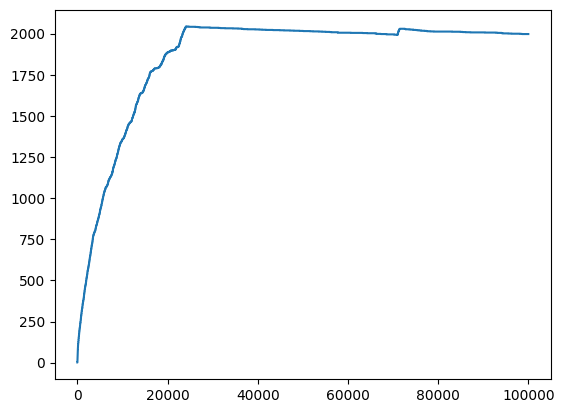

In [4]:
plt.plot(result[0])


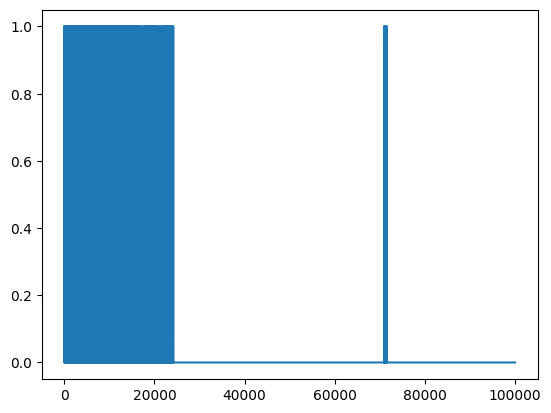

In [5]:
plt.plot(result[1])

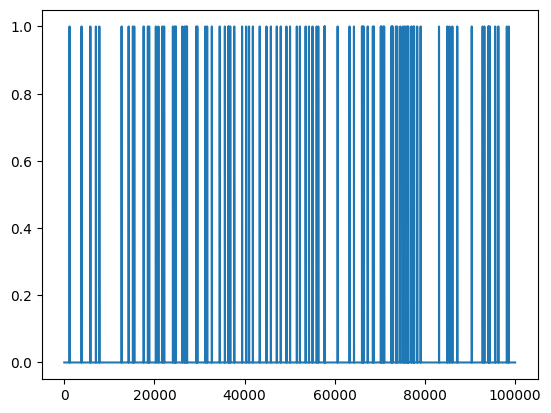

In [7]:
plt.plot(result[2])

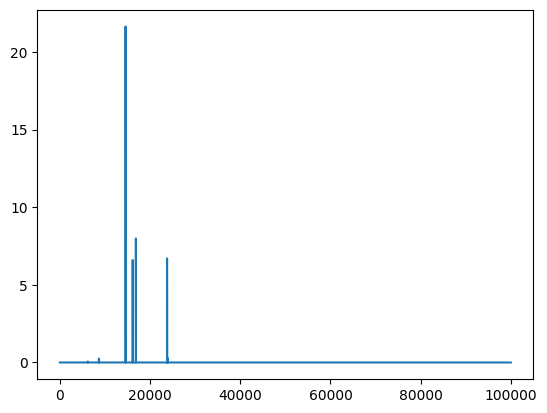

In [8]:
plt.plot(result[3])


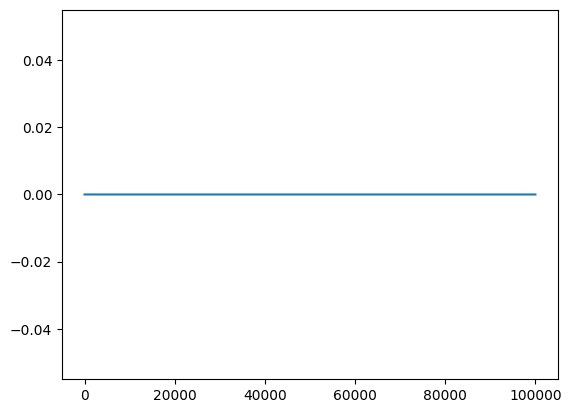

In [9]:
plt.plot(result[4])